In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from feature_vae import FeatureVAE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split

/Users/thomas/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
z_dim = 12
beta = 2

num_epochs = 50
batch_size = 64
gradient_accumulation_steps = 1
lr = 1e-3

updates_per_epoch = 1
num_displays = 3

In [3]:
rand_state = 420

torch.manual_seed(rand_state)
np.random.seed(rand_state)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
shapes_meta = pd.read_csv('shapes.csv')
shapes_meta.head()

,shape,color,r,g,b,wscale,hscale,rotation,skew,xcenter,ycenter,hatch,shadow
0,heptagon,dark teal,0.003922,0.301961,0.305882,1.000000,1.000000,0.0,0.00000,-16.321058,25.594601,NaN,False
1,heptagon,purply pink,0.941176,0.458824,0.901961,0.772384,0.772384,0.0,0.00000,-37.313314,37.195328,NaN,False
2,arrow,brownish yellow,0.788235,0.690196,0.011765,1.314330,1.314330,0.0,27.50587,-0.538244,0.000000,NaN,False
3,triangle,ugly purple,0.643137,0.258824,0.627451,0.711226,0.711226,0.0,0.00000,0.000000,0.000000,NaN,True
4,octagon,medium green,0.223529,0.678431,0.282353,0.954740,0.854899,0.0,0.00000,0.000000,0.000000,-,False


In [6]:
resize = transforms.Resize(64)
shapes = resize(torch.load('shapes.pt').permute(0, 3, 1, 2) / 255)
del resize
shapes.shape

torch.Size([20000, 3, 64, 64])

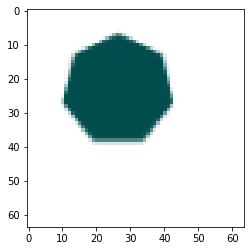

In [7]:
plt.imshow(shapes[0].permute(1, 2, 0).cpu())

In [8]:
train, valid = train_test_split(shapes, test_size=0.1, random_state=rand_state)
train_meta, valid_meta = train_test_split(shapes_meta, test_size=0.1, random_state=rand_state)
del shapes

In [9]:
train_meta, valid_meta = train_test_split(shapes_meta, test_size=0.1, random_state=rand_state)
train_meta = torch.tensor(train_meta.iloc[:,2:5].values).float()
valid_meta = torch.tensor(valid_meta.iloc[:,2:5].values).float()

In [10]:
num_features = train_meta.size(1)

In [11]:
from torch.utils.data import Dataset

bce_loss = nn.BCELoss(reduction='sum')
def vae_loss(x, mu, var, recon, beta):
    recon_loss = bce_loss(recon, x)
    kl = -torch.sum(1 + var - torch.pow(mu, 2) - torch.exp(var)) / 2
    return (recon_loss + beta * kl) / x.size(0)

class DatasetWrapper(Dataset):
    def __init__(self, imgs, latent_supervision):
        self.imgs = imgs
        self.latent_supervision = latent_supervision
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        return self.imgs[idx].to(device), self.latent_supervision[idx].to(device)

Epoch 1: 100%|█████████▉| 281/282 [01:04<00:00,  4.58it/s]

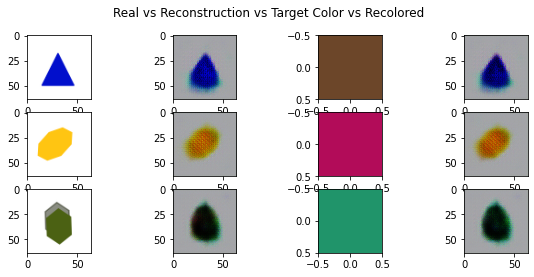

Epoch 1 | train loss 7073.85 | valid loss 6098.91: 100%|██████████| 282/282 [01:07<00:00,  4.19it/s]
Epoch 2: 100%|█████████▉| 281/282 [01:05<00:00,  4.27it/s]

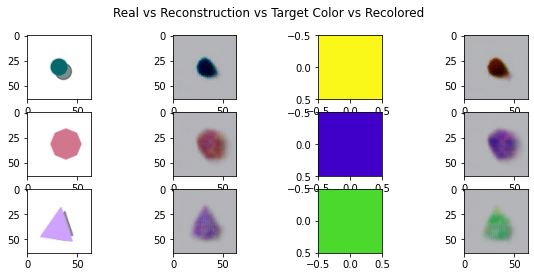

Epoch 2 | train loss 5540.56 | valid loss 5001.79: 100%|██████████| 282/282 [01:08<00:00,  4.10it/s]
Epoch 3: 100%|█████████▉| 281/282 [01:08<00:00,  4.18it/s]

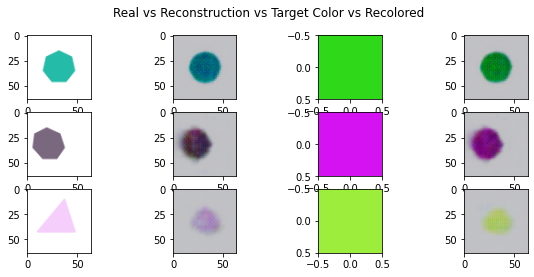

Epoch 3 | train loss 4595.21 | valid loss 4178.76: 100%|██████████| 282/282 [01:11<00:00,  3.92it/s]
Epoch 4: 100%|█████████▉| 281/282 [01:06<00:00,  4.34it/s]

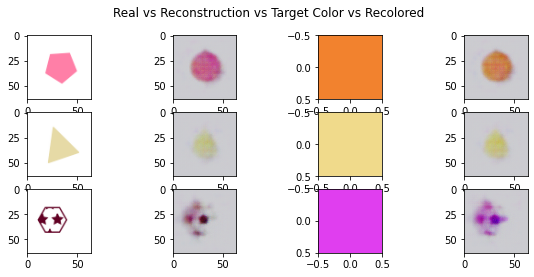

Epoch 4 | train loss 3901.23 | valid loss 3616.89: 100%|██████████| 282/282 [01:09<00:00,  4.03it/s]
Epoch 5: 100%|█████████▉| 281/282 [01:05<00:00,  4.37it/s]

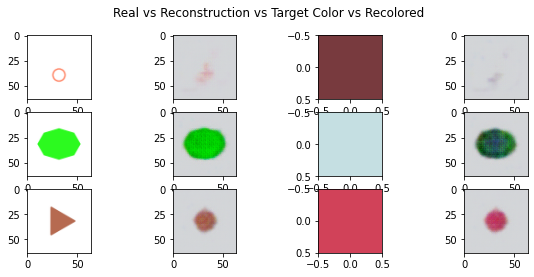

Epoch 5 | train loss 3371.85 | valid loss 3055.77: 100%|██████████| 282/282 [01:08<00:00,  4.10it/s]
Epoch 6: 100%|█████████▉| 281/282 [01:03<00:00,  4.47it/s]

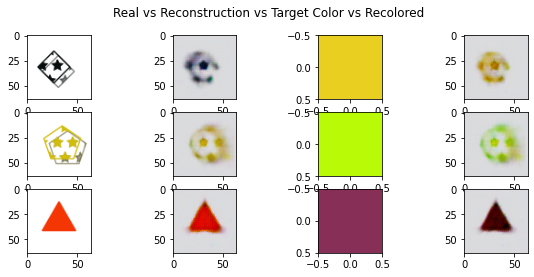

Epoch 6 | train loss 2963.88 | valid loss 2936.05: 100%|██████████| 282/282 [01:06<00:00,  4.24it/s]
Epoch 7: 100%|█████████▉| 281/282 [01:03<00:00,  4.50it/s]

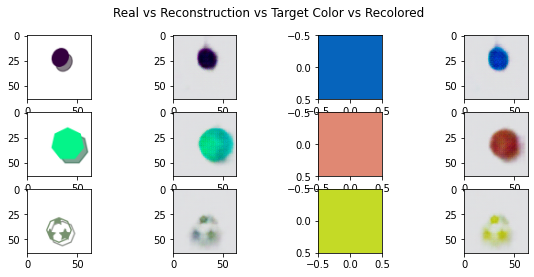

Epoch 7 | train loss 2653.46 | valid loss 2476.14: 100%|██████████| 282/282 [01:06<00:00,  4.25it/s]
Epoch 8: 100%|█████████▉| 281/282 [01:02<00:00,  4.59it/s]

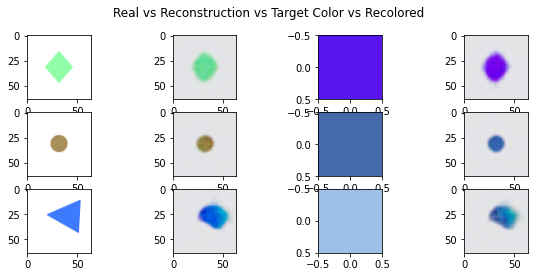

Epoch 8 | train loss 2401.34 | valid loss 2358.08: 100%|██████████| 282/282 [01:05<00:00,  4.30it/s]
Epoch 9: 100%|█████████▉| 281/282 [01:00<00:00,  4.71it/s]

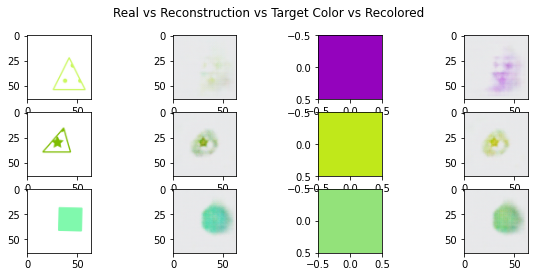

Epoch 9 | train loss 2197.59 | valid loss 2166.94: 100%|██████████| 282/282 [01:03<00:00,  4.43it/s]
Epoch 10:  96%|█████████▌| 271/282 [00:59<00:02,  4.52it/s]

In [ ]:
from torch.utils.data import DataLoader

net = FeatureVAE(z_dim, num_features)
net = net.to(device)
optimizer = torch.optim.AdamW(net.parameters(), lr=lr)

train_dataloader = DataLoader(DatasetWrapper(train, train_meta), batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(DatasetWrapper(valid, valid_meta), batch_size=batch_size, shuffle=True)

num_batches = len(train_dataloader)
num_valid_batches = len(valid_dataloader)


train_losses, valid_losses = [], []

update_idxs = set([i * (num_batches // updates_per_epoch)
    for i in range(1, updates_per_epoch)] + [num_batches])

best_valid = 1e9
for epoch in range(1, 1+num_epochs):
    total_loss = 0.0 

    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch}", leave=True, total=num_batches)
    optimizer.zero_grad()
    for idx, batch in enumerate(pbar, start=1):
        x, latent_supervision = batch

        recon, mu, var, z = net(x, latent_supervision)
        
        loss = vae_loss(x, mu, var, recon, beta)

        total_loss += loss.item() / gradient_accumulation_steps
        loss = loss / gradient_accumulation_steps
        loss.backward()
        
        if (idx % gradient_accumulation_steps == 0) or (idx == num_batches):
            optimizer.step()
            optimizer.zero_grad()

        if idx in update_idxs:
            avg_valid_loss = 0.0
            
            displays = []
            net.eval()
            with torch.no_grad():
                for batch in valid_dataloader:
                    x, latent_supervision = batch
                    recon, mu, var, z = net(x,latent_supervision)
                    loss = vae_loss(x, mu, var, recon, beta)
                    
                    avg_valid_loss += loss.item() / num_valid_batches
                    if not displays:
                        net.random_z = tuple(z[0].detach().cpu().numpy())
                        
                        rand_colors = torch.rand(num_displays, num_features).to(device)
                        recon2 = net.generate(z[:num_displays], rand_colors)
                        
                        for j in range(num_displays):
                            displays.append((
                                x[j].permute(1, 2, 0).cpu().numpy(),
                                recon[j].permute(1, 2, 0).cpu().numpy(),
                                rand_colors[j].cpu().numpy()[None, None, :],
                                recon2[j].permute(1, 2, 0).cpu().numpy()
                            )
                            )
                
                if avg_valid_loss < best_valid:
                    torch.save(net, f'models/{beta}-featurevae-{z_dim}dim')
                    best_valid = avg_valid_loss
                    
                valid_losses.append(avg_valid_loss)
                
                if idx == num_batches:
                    fig, axes = plt.subplots(num_displays, 4)
                    fig.suptitle('Real vs Reconstruction vs Target Color vs Recolored')
                    fig.set_size_inches(10, 4)
                    for ax, im in zip(axes, displays):
                        for axi, imi in zip(ax, im):
                            axi.imshow(imi)
                    plt.show()
            net.train()


            pbar.set_description(f"Epoch {epoch} | train loss {total_loss / idx:.2f}" + \
                                f" | valid loss {avg_valid_loss:.2f}")
            train_losses.append(total_loss / idx) 

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.legend()
plt.show()